In [1]:
import sys
import os

from math import *
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
import handcalcs.render
from handcalcs.decorator import handcalc
import forallpeople as si
from IPython.display import display, Latex
from PySide6.QtCore import Qt 
from PySide6.QtWidgets import QApplication, QInputDialog


sys.path.append(os.path.join(os.getcwd(), "catalog", "eurocode"))
import A0_Projet as A0
import A1_MEF as A1
import EC0_Combinaison as EC0
import EC5_Assemblage as EC5_Ass
import EC5_Element_droit as EC5_Ele

# N° projet - Projet - Note de calcul
---
## Élément :
- Annexe : ANxx
- Date : 03/10/2022
- Ingénieur : Anthony PARISOT
---

## 1. Paramètres
----

- <font color="blue" size ="5">**Dalle**</font>

In [2]:
app = QApplication()
disposition, ok = QInputDialog.getItem(
    None, "Position des planches", "Position des planches :", ["Latérale", "Dessus / Dessous"], 0, False, flags=Qt.FramelessWindowHint)

# longueur, ok = QInputDialog.getInt(
#         None, "Longueur dalle", "Longueur dalle :", 0, minValue= 0, step=100, flags=Qt.FramelessWindowHint)

verif_barre, ok = QInputDialog.getItem(
    None, "Barre à vérifier", "Barre à vérifier :", ["Planche_intermédiaire", "Planche_basse"], 0, False, flags=Qt.FramelessWindowHint)

In [3]:
#recouvrement (int):Cela correspond à la distance entre le centre géométrique de la pièce 2 et celui de la pièce i. ATTENTION z local est vers le bas quand vous donnez le recouvrement.

In [4]:
%%render params 2
longueur = 4000 * si.mm
disposition
classe_service = 1
humidite_initiale = 12 #pourcent
humidite_finale = 12 #pourcent
recouvrement = -40 #mm
entraxe_connecteurs = 200 #mm
verif_barre = verif_barre

<IPython.core.display.Latex object>

In [5]:
def calcs_number_node(long):
        """Retourne le nombre de d'élément pour le maillage MEF

        Returns:
            int: nombre d'élément MEF
        """
        round_long = ceil(long/10)*10
        
        if round_long <= 1000:
            ele = int(round_long/10)
        elif round_long <= 10000:
            ele = int(round_long/100)
        else:
            ele = int(round_long/200)
        return ele
    
node = calcs_number_node(longueur.value*10**3)

- <font color="blue" size ="5">**Planche basse**</font>

In [6]:
%%render params 2
b_planche_basse = 77 * si.mm
h_planche_basse = 360 * si.mm
classe_bois_planche_basse = "C24"


<IPython.core.display.Latex object>

In [7]:
projet = A0.Projet(code_INSEE=73215, alt= 0)
barre2 = EC5_Ass.Barre._from_parent_class(projet, b=b_planche_basse.value*10**3, h=h_planche_basse.value*10**3, section="Rectangulaire", Hi=humidite_initiale, Hf=humidite_finale, classe=classe_bois_planche_basse, cs=classe_service, effet_systeme="False")
pd.DataFrame(barre2.caract_meca).T

,fm0k,ft0k,ft90k,fc0k,fc90k,fvk,E0mean,E005,E90mean,Gmoy,rhok,rhomean
C24,24,14.5,0.4,21,2.5,4,11000,7400,370,690,350,420


- <font color="blue" size ="5">**Planche haute**</font>

In [8]:
%%render params 2
b_planche_intermediaire = 83 * si.mm
h_planche_intermediaire = 120 * si.mm
classe_bois_planche_intermediaire = "C24"

<IPython.core.display.Latex object>

In [9]:
barre3 = EC5_Ass.Barre._from_parent_class(projet, b=b_planche_intermediaire.value*10**3, h=h_planche_intermediaire.value*10**3, section="Rectangulaire", Hi=humidite_initiale, Hf=humidite_finale, classe=classe_bois_planche_intermediaire, cs=classe_service, effet_systeme="False")
pd.DataFrame(barre3.caract_meca).T

,fm0k,ft0k,ft90k,fc0k,fc90k,fvk,E0mean,E005,E90mean,Gmoy,rhok,rhomean
C24,24,14.5,0.4,21,2.5,4,11000,7400,370,690,350,420


- <font color="blue" size ="5">**Connecteurs**</font>

In [10]:
%%render params 2
d = 6 * si.mm
d1 = 3.9 * si.mm
ds = 4.3 * si.mm
dh = 12 * si.mm
l = 200 * si.mm
rho_a = 350 * si.kg / si.m**3
fhead = 10.5 * si.MPa
ftensk = 11300 * si.N
MyRk = 9494 * si.N*si.mm
alpha1 = 90 #°
alpha2 = 90 #°

<IPython.core.display.Latex object>

In [11]:
assemblage = EC5_Ass.Assemblage._from_parent_class(projet, beam_1=barre3, beam_2=barre2, nfile=1, nCis=2)

In [12]:
if d1.value*10**3*1.1 > 6:
    connecteur = EC5_Ass.Tirefond_sup_6._from_parent_class(assemblage, d=d.value*10**3, d1=d1.value*10**3, ds=ds.value*10**3, dh=dh.value*10**3, l=l.value*10**3, n=1, rho_a=rho_a.value, fhead=fhead.value*10**-6, ftensk=ftensk.value, MyRk=MyRk.value*10**3, alpha1=alpha1, alpha2=alpha2)
else:
    connecteur = EC5_Ass.Tirefond_inf_7._from_parent_class(assemblage, d=d.value*10**3, d1=d1.value*10**3, ds=ds.value*10**3, dh=dh.value*10**3, l=l.value*10**3, n=1, rho_a=rho_a.value, fhead=fhead.value*10**-6, ftensk=ftensk.value, MyRk=MyRk.value*10**3, alpha1=alpha1, alpha2=alpha2, percage = False)

In [13]:
match verif_barre:
    case "Planche_basse":
        index_barre=2
        barre = deepcopy(barre2)
    case "Planche_intermédiaire":
        index_barre=3
        barre = deepcopy(barre3)

## 2. Chargement
---

In [14]:
Charge1 = [1, '', 'Permanente G', 'Linéique', -10, '0/2000', 'Z']
Charge2 = [0, 'Poids propre', 'Permanente G', 'Linéique', -36, '0/2000', 'Z']
Charge3 = [2, '', 'Neige normale Sn', 'Linéique', -200, '0/2000', 'Z']
Charge4 = [3, '', 'Exploitation Q', 'Linéique', -150, '0/2000', 'Z']

In [15]:
_list_loads = [Charge1,Charge2, Charge3, Charge4]
_list_loads

[[1, '', 'Permanente G', 'Linéique', -10, '0/2000', 'Z'],
 [0, 'Poids propre', 'Permanente G', 'Linéique', -36, '0/2000', 'Z'],
 [2, '', 'Neige normale Sn', 'Linéique', -200, '0/2000', 'Z'],
 [3, '', 'Exploitation Q', 'Linéique', -150, '0/2000', 'Z']]

## 3. Combinaisons d'action
---

In [16]:
chargement = EC0.Chargement(pays="France")
chargement.create_load_by_list(_list_loads)
c1 = A1.Combinaison._from_parent_class(chargement, cat="Cat A : habitation")
rcombi = "ELU_STR 1.35G + 1.5Sn + 1.05Q"
c1.get_combi_list_load(rcombi)

listdeplacement = [[1, "Rotule", 0, 40], [2, "Rotule", 2000, 40]]

In [17]:
action = c1.min_type_load(rcombi)
kmod = barre.K_mod_table[action].iloc[0]
gamma_M = barre.gamma_M_table.iloc[0]

In [18]:
print(action, kmod,gamma_M)

Court terme 0.9 1.3


In [19]:
pd.DataFrame(c1.list_combination)

,Combinaison
0,ELS_C G
1,ELS_C G + Q
2,ELS_C G + Q + 0.5Sn
3,ELS_C G + Sn
4,ELS_C G + Sn + 0.7Q
5,ELS_QP G
6,ELS_QP G + 0.3Q
7,ELU_STR 1.35G
8,ELU_STR 1.35G + 1.5Q
9,ELU_STR 1.35G + 1.5Q + 0.75Sn


## 4. Assemblage
----

- <font color="blue" size ="5">**Kser par vis et par plan de cisaillement**</font>

In [20]:
Kser = connecteur.Kser
display(Latex(Kser[0]))

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Kser assemblage**</font>

In [21]:
Kser_ass = connecteur.Kser_ass
display(Latex(Kser_ass[0]))

<IPython.core.display.Latex object>

In [22]:
dalle = EC5_Ele.Poutre_assemblee_meca(beam_2=barre2, l=longueur.value*10**3, disposition=disposition, recouvrement=[0,recouvrement], Kser=[None,None,Kser_ass[1]], entraxe=[None,None,entraxe_connecteurs], psy_2=0, beam_3=barre3)


- <font color="blue" size ="5">**Kser final tenant compte du fluage**</font>

In [23]:
Kser_fin = dalle.Kser_fin
display(Latex(Kser_fin["Kser fin 2-3"][0]))

<IPython.core.display.Latex object>

## 5. Rigidité efficace de la poutre assemblée mécaniquement
----

- <font color="blue" size ="5">**Gamma, facteur de glissement des connecteurs**</font>

In [24]:
gamma = dalle.gamma_i
gamma_2 = gamma["gamma 2"]
gamma_3 = gamma["gamma 3"][0]

display(Latex(gamma_3))

<IPython.core.display.Latex object>

In [25]:
%%render params 0

gamma_2

<IPython.core.display.Latex object>

- <font color="blue" size ="5">**Distance de l'axe de la pièce par rapport à l'axe neutre de l'assemblage**</font>

In [26]:
data = {"Planche":["Planche basse","Planche intermédiaire"],
        "Distance à l'axe neutre":[dalle.distance_ai[1],dalle.distance_ai[2]]}
distanceai = pd.DataFrame(data)
distanceai

,Planche,Distance à l'axe neutre
0,Planche basse,2.581 mm
1,Planche intermédiaire,-37.419 mm


- <font color="blue" size ="5">**Rigidité efficace en flexion**</font>

In [27]:
ei_eff = dalle.EI_eff
display(Latex(ei_eff[0]))


<IPython.core.display.Latex object>

## 6. Efforts tranchants Vz
----

In [28]:
l = int(ceil(dalle.l.value * 10**3))
E_mean_fin = int(barre2.E_mean_fin.value*10**-6)
A = barre2.b * barre2.h + barre3.b * barre3.h
A = A.value*10**6
iy = ei_eff[1].value*10**6 / E_mean_fin
G = float(barre2.caract_meca.Gmoy)
test = A1.MEF._from_parent_class(c1, long=l, E=E_mean_fin, A=A, G=G, J=1, Iy=iy, Iz=1, ele=node, alphaZ=0, alphaY=0, alphaX=0)
test.create_supports_by_list(listdeplacement)

test.calcul_1D()

168


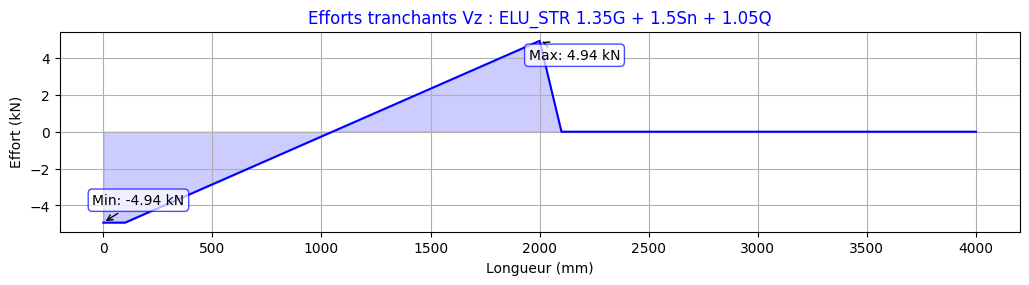

In [29]:
test.show_graphique_Vz(rcombi)

## 7. Moments My
----

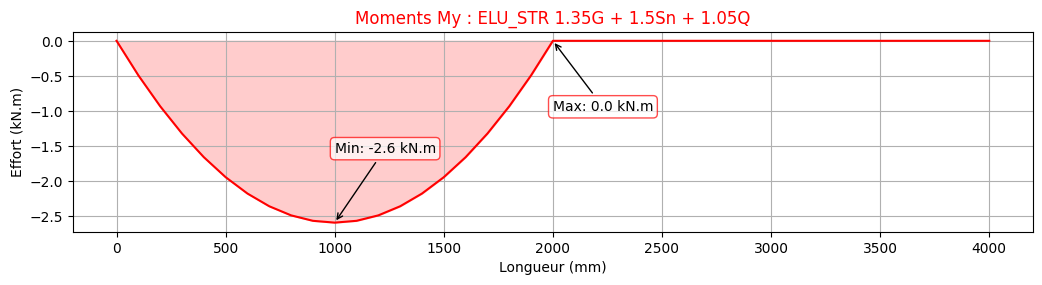

In [30]:
test.show_graphique_My(rcombi)

## 8. Déformations selon l'axe Z
----

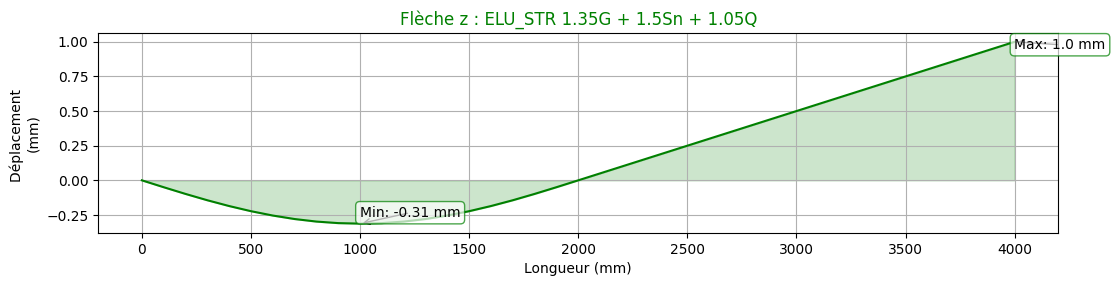

In [31]:
test.show_graphique_fleche(rcombi)

## 9. Tableau récapitulatif des efforts internes
----

In [32]:
df = pd.DataFrame(test.effort_interne_max())
df

,Nx_max,Nx_min,Vz_max,Vz_min,My_max,My_min
Position,0.000000,2100.000000,2000.000000,0.000000,2000.000000,1000.000000
Effort,0.000001,-0.000006,4.936208,-4.936186,0.000022,-2.597987


## 10. Contrainte de cisaillement maximale dans l'élément 2 selon Annexe B.4 de l'EN 1995
---

In [33]:
V_z = max(df['Vz_max']['Effort'],abs(df['Vz_min']['Effort']))
tau_2 = dalle.tau_2_max(V_z)
display(Latex(tau_2[0]))

<IPython.core.display.Latex object>

## 11. Contrainte de compression parallèle au fil selon Annexe B.3 de l'EN 1995
----

In [34]:
M_y = max(df['My_max']['Effort'],abs(df['My_min']['Effort']))
sigma_i = dalle.sigma_i(M_y, beam=index_barre)
display(Latex(sigma_i[0]))

<IPython.core.display.Latex object>

## 12. Contrainte de flexion le long de l'axe y selon Annexe B.3 de l'EN 1995
----

In [35]:
sigma_mi = dalle.sigma_mi(M_y, beam=index_barre)
display(Latex(sigma_mi[0]))

<IPython.core.display.Latex object>

## 13. Charge à reprendre par organe d'assemblage selon Annexe B.5 de l'EN 1995
----

In [36]:
F_i = dalle.F_i(V_z, connecteur=2)
display(Latex(F_i[0]))

<IPython.core.display.Latex object>

In [37]:
fh1k = connecteur.fh1k
display(Latex(fh1k[0]))

fh2k = connecteur.fh2k
display(Latex(fh2k[0]))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [38]:
nef = connecteur.nef(a1_beam1=entraxe_connecteurs, a1_beam2=entraxe_connecteurs)
display(Latex(nef[0]))

<IPython.core.display.Latex object>

In [39]:
connecteur.nfile

1

In [40]:
FvRk = connecteur.FvRk(False)
display(Latex(FvRk[0]))

<IPython.core.display.Latex object>

## 14. Résistance de calcul en flexion

In [41]:
beam_3_flexion = EC5_Ele.Flexion._from_parent_class(barre, lo=longueur.value*10**3, coeflef=0.9, pos="Charge sur fibre comprimée")
beam_3_flexion.sigma_m_rd = {'y': sigma_mi[1], 'z': 0 * si.MPa}
fmd = beam_3_flexion.f_m_d(action, "Fondamentales")
display(Latex(fmd[0]))


<IPython.core.display.Latex object>

In [42]:
print(beam_3_flexion.coeflef)

0.9


In [43]:
if sigma_i[1] < 0:
    beam_3_compression = EC5_Ele.Compression._from_parent_class(barre,  lo_y=longueur.value*10**3, lo_z=longueur.value*10**3, type_appuis= "Rotule - Rotule")
    fc0d = beam_3_compression.f_c_0_d(action, "Fondamentales")
    beam_3_compression.sigma_c_0_rd = abs(sigma_i[1])
    taux_compression = beam_3_compression.taux_c_0_d()
    print("Barres en compression :")
    display(Latex(taux_compression[0]))
    taux_flexion = beam_3_flexion.taux_m_d(compression=beam_3_compression)
    display(Latex(taux_flexion[0]))
else:
    beam_3_traction = EC5_Ele.Traction._from_parent_class(barre)
    ft0d = beam_3_traction.f_t_0_d(action, "Fondamentales")
    beam_3_traction.sigma_t_0_rd = sigma_i[1]
    taux_traction = beam_3_traction.taux_t_0_d()
    print("Barres en traction :")
    display(Latex(taux_traction[0]))
    taux_flexion = beam_3_flexion.taux_m_d(traction=beam_3_traction)
    display(Latex(taux_flexion[0]))
    

Barres en compression :


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [44]:
app.exit()

In [45]:
# yG = dalle.distance_ai[1] + barre2.h_calcul/2
# yG = yG.value *10**3
# y = [h for h in range(0, int(barre2.h_calcul.value*10**3)+20, 20)]

# sigma_m = []
# tau = []
# My = M_y.value*10**3
# Vz = V_z.value
# E_mean_fin_3 = dalle.beam[2].E_mean_fin.value *10**-6
# ei_eff = dalle.EI_eff[1].value *10**6
# beam_2 = dalle.beam[1]
# beam_3 = dalle.beam[2]
# h3 = (dalle.beam[1].h_calcul.value/2 - dalle.recouvrement[1].value- dalle.beam[2].h_calcul.value/2)*10**3
# print(h3, dalle.beam[1].h_calcul.value, dalle.recouvrement[1].value, dalle.beam[2].h_calcul.value)

# tau_value = 0
# for h in y:
#     for yi in y:
#         for index, beam in enumerate(dalle.beam):
#             if beam_2.h_calcul.value *10**3 <=yi:
#                 if beam is not None:
#                     gamma_i = dalle.gamma_i["gamma 2"]
#                     E_mean_fin = beam_2.E_mean_fin.value *10**-6
#                     b = dalle.beam[1].b_calcul.value *10**3
#                     h = dalle.beam[1].h_calcul.value *10**3
#                     distance_ai = dalle.distance_ai[1].value *10**3
#                     h_z = h
#                     for yi in y:
#                         if yi < h:
#                             h_z = yi
#                         else:
#                             h_z = h
                        
#                         tau_2 = (Vz*gamma_i*E_mean_fin*b*h_z*distance_ai)/(ei_eff*b) 
#                         tau_value = tau_value + tau_2
#                         print (tau_value, h_z, gamma_i)
#             elif h3 <=yi:
#                 if beam is not None:
#                     gamma_i = dalle.gamma_i["gamma 3"][1]
#                     print(gamma_i)
#                     E_mean_fin = beam_3.E_mean_fin.value *10**-6
#                     b = dalle.beam[2].b_calcul.value *10**3
#                     h = dalle.beam[2].h_calcul.value *10**3
#                     distance_ai = dalle.distance_ai[2].value *10**3
#                     h_z = h+h3
#                     for yi in y:
#                         if yi < h_z:
#                             h_z = yi
#                         else:
#                             h_z = h_z
#                         print(Vz,gamma_i,E_mean_fin,b,h_z,distance_ai,ei_eff,b)
#                         tau_3 = (Vz*gamma_i*E_mean_fin*b*h_z*distance_ai)/(ei_eff*b) 
#                         tau_value = tau_value + tau_3
#                         print (tau_value, h_z, gamma_i)
#     tau.append(tau_value)
        
# for h in y:
#     v = yG - h
#     sigma_m.append(My * E_mean_fin_3 * v / ei_eff)

# plt.figure(figsize=(14,7))
# plt.title("Contrainte de flexion Sigma,m")
# plt.xlabel("Contrainte en MPa")
# plt.ylabel("Hauteur de la poutre en mm")

# plt.plot(sigma_m, y)
# plt.plot(tau, y)

# plt.plot([0] * len(y), y, color='red')
# x = np.arange(int(min(sigma_m))-10, int(max(sigma_m))+10, step=2)
# plt.plot(x, [yG] * len(x), color='red')

# plt.grid(True)
# plt.xticks(np.arange(int(min(sigma_m))-5, int(max(sigma_m))+5, step=2))
# plt.yticks(np.arange(int(min(y)), int(max(y)+10), step=10))

# if abs(int(min(sigma_m))) > abs(int(max(sigma_m))):
#     sigma_max  = round(min(sigma_m),2)
# else:
#     sigma_max = round(max(sigma_m),2)
# if abs(int(min(tau))) > abs(int(max(tau))):
#     tau_max  = round(min(tau),2)
# else:
#     tau_max = round(max(tau),2)
# plt.text(sigma_max, int(yG) +10, f"yG: {round(yG,1)}mm", color="red")
# plt.text(sigma_max, int(barre2.h_calcul.value*10**3 / 2 - 50), f"contrainte max flexion: \n{sigma_max} MPa", color="blue")
# plt.text(tau_max, int(barre2.h_calcul.value*10**3 / 2 - 50), f"contrainte max cisaillement : \n{tau_max} MPa", color="orange")
# plt.show()